# Libraries Used

In [177]:
import pandas as pd
import re # regular expressions
import os
import matplotlib.pyplot as plt
import numpy as np

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords # dictionart of Standard english words
from nltk.stem import WordNetLemmatizer # lematizes a word based on context

# Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Loading

In this section I use the os and pandas libraries to extract the text files and convert them into a dataframe where the first column is the subject of the notebook and the second is all the text from the notebook. I optimised my code to work on the given structure of the text files meaning that I didn't have to move files around to run this. For loading the files simply change the 'dir_fol_path' variable to the directory of the folder. 

I also used the re (Regular Expressions) library to rename the values of the first column of the created dataframe as this originally consisted of the filenames of the text files

In [69]:
# set the folder directory path containing text files
dir_fol_path = "C:/Users/PanSt/OneDrive/Υπολογιστής/Adarga/data/"

# set the paths from the folder containing text files
dir_subpath = ['Computer_Science/Computer_Science/','Maths/','History/']

# initialize empty lists for filenames and text content
file_names = []
file_contents = []

# loop through each folder in direcroty
for folder in dir_subpath:
    dir_path = dir_fol_path + folder
    # loop through each file in directory
    for filename in os.listdir(dir_path):
        # check if file is a text file
        if filename.endswith('.txt'):
            # append file name to list
            file_names.append(filename)
            # read in file contents and append to list
            with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as f:
                file_contents.append(f.read())

# create Pandas dataframe with two columns: file name and file content
df = pd.DataFrame({'category': file_names, 'text': file_contents})

# rename the cells in the 'Category' column
for i, name in enumerate(df['category']):
    # check if the name starts with 'Comp'
    if re.match('^Comp', name):
        # if it does, rename the cell to 'CS'
        df.at[i, 'category'] = 'CS'
    # check if the name starts with 'Math'        
    if re.match('^Math', name):
        # if it does, rename the cell to 'Maths'
        df.at[i, 'category'] = 'Maths'
    # check if the name starts with 'Hist'        
    if re.match('^Hist', name):
        # if it does, rename the cell to 'History'
        df.at[i, 'category'] = 'History'

df.head()

,category,text
0,CS,84 Chapter 2 Instructions: Language of the Com...
1,CS,2.7 Supporting Procedures In Computer Hardware...
2,CS,86 Chapter 2 Instructions: Language of the Com...
3,CS,2.7 Supporting Procedures in Computer Hardware...
4,CS,88 Chapter 2 Instructions: Language of the Com...


<AxesSubplot: >

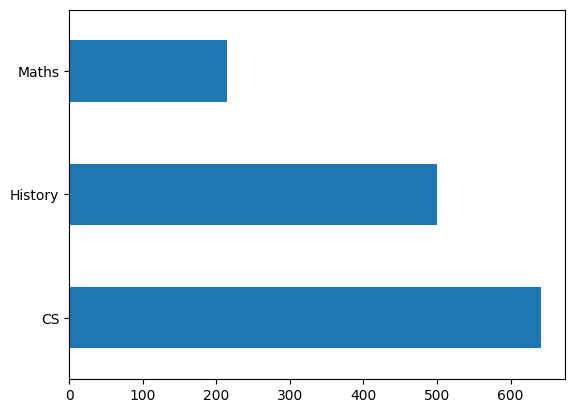

In [70]:
df['category'].value_counts().plot(kind='barh')

In [71]:
df.shape

(1356, 2)

In [72]:
# check for missing values
df.isna().sum()

category    0
text        0
dtype: int64

# Preprocessing

In this section I use the re library to preprocess and clean the data. The following steps were performed: 

- Remove all special characters
- Lowercase all the words
- Tokenize
- Remove stopwords
- Lemmatize

In [73]:
#nltk.download('all')

# Convert 'text' column of the datafrane to a list
text = list(df['text'])
lemmatizer = WordNetLemmatizer() # initialise lemmatizer
corpus = [] # initialise corpus

# for each element in the list
for i in range(len(text)):

    r = re.sub('[^a-zA-Z]', ' ', text[i]) # remove all characters that are non alphabets
    r = r.lower() # lowercase all alphabet words
    r = r.split() # split string into individual words
    r = [word for word in r if word not in stopwords.words('english')] # Keep only non-standard engligh words
    r = [lemmatizer.lemmatize(word) for word in r] # lemmatize the word using the lemmatizer
    r = ' '.join(r) # join the lemmatized words back
    corpus.append(r) # add the lemmatized words to the ith index in the corpus list

# assign corpus list to data['text']
df['text'] = corpus

df.head()

,category,text
0,CS,chapter instruction language computer paramete...
1,CS,supporting procedure computer hardware next va...
2,CS,chapter instruction language computer allocati...
3,CS,supporting procedure computer hardware allocat...
4,CS,chapter instruction language computer lead mem...


# Model development

In this seciton I develop the machine learning model using logistic regression. The count vectorizer uses word-level tokenization and converts keeping unique words and their respective frequency

In [158]:
"""
This function develops a machine learning model
model: machine learning model used (e.x. LogisticRegression())
"""
def model_development(model):
    # set features and target variables
    X = df['text']
    y = df['category']


    # train test split (80% train - 20% test)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #include random state for reproducible results

    cv = CountVectorizer() #initialise the vectorizer
    X_train_cv = cv.fit_transform(x_train) # vectorize the train x data using the vectorizer 
    
    if model == 'LogisticRegression':
        ml_model = LogisticRegression() # initialise the logistic regression model
        ml_model.fit(X_train_cv, y_train) # fit the logistic regression model with the vectorized x data and the training target variables (subject)

    # transform X_test using CV
    X_test_cv = cv.transform(x_test) # vectorize the test x data using the vectorizer

    # generate predictions
    predictions = ml_model.predict(X_test_cv) # make predicitons on the test data
    return (predictions, y_test)

# Evaluation

In [179]:
"""
This function plots a confusion matrix using a colormap
cm: Confusion matrix data
classes: List of class names
"""

def plot_confusion_matrix(cm, classes):

    cmap=plt.cm.Blues
    # create figure and axes
    fig, ax = plt.subplots()
    # normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot confusion matrix
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=cmap)

    # add colorbar
    fig.colorbar(im)

    # set labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, "{:.2f}".format(cm_normalized[i, j]),
                           ha="center", va="center", color="black")

    # set title
    ax.set_title("Confusion Matrix")

    # set axis labels
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # set figure layout
    fig.tight_layout()

    # show plot
    plt.show()

In [182]:
"""
This function evaluates the machine learning model developed
predictions: expected y values
y_test: actual y values
"""

def model_evaluation(predictions, y_test):
    # confusion matrix
    cm_exp = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['CS','Maths','History'], columns=['CS','Maths','History'])
    cm_obs = pd.DataFrame(metrics.confusion_matrix(y_test,y_test), index=['CS','Maths','History'], columns=['CS','Maths','History'])
    acc_score = round(metrics.accuracy_score(y_test,predictions),4)
    chi_sq = round((((cm_obs-cm_exp)**2)/cm_exp).sum().sum(),4)
    plot_confusion_matrix(np.array(cm_exp),['CS','Maths','History'])
    print('chi square = {}, accuracy score = {}'.format(chi_sq, acc_score))

# Model development and evaluation

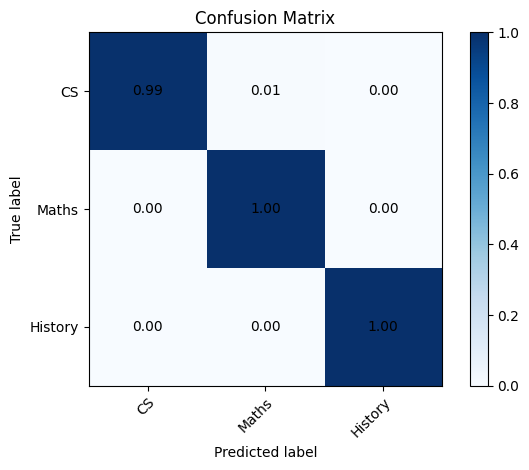

chi square = 1.0073, accuracy score = 0.9963


In [184]:
predictions, y_test = model_development('LogisticRegression')
model_evaluation(predictions, y_test)

# Improvements

The model used is very accurate and thats is not a case of overfitting. To better test the model, a larger dataset could be used, or alter the train_test_split funciton (although that will compromise the training of the model). Other classification models could be developed and compared with logistic regresison such as the SVM and KNN (k=3) models. In the preprocessing stage of the model, I ommitted all characters that are not letters (a-zA-Z). Keeping certain symbols such as +, -, *, /, etc. could improve the accuracy of the model espcially when it comes to accurately predicting mathematics notebooks.

